In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

child = pd.read_csv("Case Record Export_dec11-dec17.csv")
vol = pd.read_csv("Volunteer Record Export_dec11-dec17.csv")
match = pd.read_csv("Match Export_dec11-dec17.csv")
goals = pd.read_csv("Goals Export_dec11-dec17.csv")

In [2]:
child = child.loc[:, ['Case Manager', 'Matched With', 'Waiting Date', 'Matched Date',
       'Match Completed Date', 'Parent-Interview Date',
       'Contact Number', 'First Name', 'Last Name', 'Postal Code',
       'Guardian Type', 'Borough (residence)', 'Age', 'Gender', 'Race',
       'Ethnicity', 'Religion', 'Grade Level', 'College Attending']]
child.columns = ['Case_Manager', 'Ch_Matched_With', 'Ch_Waiting_Date', 'Ch_Matched_Date',
       'Match_Completed_Date', 'Parent_Interview_Date',
       'Ch_Contact_Num', 'Ch_First', 'Ch_Last', 'Ch_Postal',
       'Guardian_Type', 'Ch_Borough', 'Ch_Age', 'Ch_Gender', 'Ch_Race',
       'Ch_Ethnicity', 'Ch_Religion', 'Grade', 'Ch_College_Attending']

In [3]:
vol = vol.loc[:, ['Case Manager', 'Matched With', 'Waiting Date', 'Matched Date',
       'Match Completed Date', 'Volunteer-Interview Date', 'Contact Number',
       'First Name', 'Last Name', 'State', 'Postal Code', 'Referral Source',
       'Age', 'Age Range','Gender',
       'Marital Status', 'Education Level', 'Race', 'Ethnicity', 'Religion',
       'Occupation', 'Industry', 'Employer', 'Self-Efficacy Score']]
vol.columns = ['Case_Manager', 'vol_Matched_With', 'vol_Waiting_Date', 'Matched_Date',
       'Match_Completed_Date', 'Volunteer_Interview_Date', 'vol_Contact_Num',
       'vol_First', 'vol_Last', 'vol_State', 'vol_Postal', 'vol_Referral_Source',
       'vol_Age', 'vol_Age_R','vol_Gender',
       'Marital_Status', 'vol_Education', 'vol_Race', 'vol_Ethnicity', 'vol_Religion',
       'Occupation', 'Industry', 'Employer', 'Self_Efficacy']

In [4]:
match = match.loc[:,['Match Number', 'Mentee Contact Number', 'Mentee First Name',
       'Mentee Last Name', 'Mentor 1 Contact Number', 'Mentor 1 First Name',
       'Mentor 1 Last Name', 'Match Days', 'Match Anniversary Month',
       'Close Initiated By', 'Close Reason']]
match.columns = ['Match Number', 'Ch_Contact_Num', 'Ch_First',
       'Ch_Last', 'vol_Contact_Num', 'vol_First',
       'vol_Last', 'Days_Matched', 'Made_Month',
       'Close_By', 'Close_Reason']

In [5]:
goals = goals.loc[:,['Goal Number', 'Category', 'Goal',
       '6 Month Status', '12 Month Status',
       'Match Number', 'Mentee Contact Number']]
goals.columns = ['Goal_Num', 'Goal_Category', 'Goal',
       '6_Month', '12_Month',
       'Match Number', 'Ch_Contact_Num']

In [6]:
#g = match.duplicated(subset='Ch_Contact_Num', keep=False)
#np.where( g == True )

**Drop volunteer and child duplicates (those that had more than one match) and merge with match database**

In [7]:
match.drop_duplicates(subset=['Ch_Contact_Num'], keep=False, inplace=True)
match.drop_duplicates(subset=['vol_Contact_Num'], keep=False, inplace=True)

In [8]:
match = match.merge(vol, on=['vol_Contact_Num', 'vol_First', 'vol_Last'])
match = match.merge(child, on=['Ch_Contact_Num', 'Ch_First', 'Ch_Last', 'Match_Completed_Date'])

In [9]:
match.drop(labels=['Ch_Matched_Date', 'Ch_Matched_With', 'vol_Matched_With', 'Case_Manager_x'], axis=1, inplace=True)

**Add SMART goals**

In [10]:
goals.head()

,Goal_Num,Goal_Category,Goal,6_Month,12_Month,Match Number,Ch_Contact_Num
0,614,Relationships,Ask my Big at least 3 questions to get to know...,Nearly Achieved,Fully Achieved,62553,53837
1,618,Self-Confidence,Admit when I make a mistake by apologizing to ...,Some Progress,Nearly Achieved,62553,53837
2,601,Academics,Ask the teacher for help if I do not understan...,No Progress,Nearly Achieved,62553,53837
3,611,Behavior,Solve problems by learning 3 positive things t...,Some Progress,Some Progress,62553,53837
4,613,Relationships,Ask my BBBS Program Manager how to get help wi...,No Progress,No Progress,63655,47994


In [11]:
goals['12_Month'] = goals['12_Month'].replace({'No Progress':1, \
                                               'Some Progress':2, 'Nearly Achieved':3, 'Fully Achieved': 4, np.NAN:0})
goals['6_Month'] = goals['6_Month'].replace({'No Progress':1, \
                                               'Some Progress':2, 'Nearly Achieved':3, 'Fully Achieved': 4, np.NAN:0})

In [12]:
# Calculate goal achievement for 6 and 12 months for each child

goals_dict6 = {}
goals_dict12 = {}
for a,b,c in zip(goals.loc[: , '12_Month'], goals.loc[: , 'Match Number'], goals.loc[: , '6_Month']):
    goals_dict12[b] = goals_dict12.get(b, 0) + a
    goals_dict6[b] = goals_dict6.get(b, 0) + c

goals_6month = pd.DataFrame.from_dict(goals_dict6, 'index').reset_index()
goals_6month.rename(columns = {'index' : 'Match Number', 0 : 'Goals_Achvd_6'}, inplace=True)

goals_12month = pd.DataFrame.from_dict(goals_dict12, 'index').reset_index()
goals_12month.rename(columns = {'index' : 'Match Number', 0 : 'Goals_Achvd_12'}, inplace=True)
goals_stats = goals_6month.merge(goals_12month, on='Match Number')

In [13]:
match = match.merge(goals_stats, on=['Match Number'], how='left')

# Feature Engineering

In [14]:
# Calculate interview to matched made time lapse for vols and children

match['Volunteer_Interview_Date'] = pd.to_datetime(match['Volunteer_Interview_Date'])
match['Matched_Date'] = pd.to_datetime(match['Matched_Date'])
match['vol_intTOmatch'] = match['Matched_Date'] - match['Volunteer_Interview_Date']

match['Parent_Interview_Date'] = pd.to_datetime(match['Parent_Interview_Date'])
match['Ch_intTOmatch'] = match['Matched_Date'] - match['Parent_Interview_Date']

# convert dt (e.g. 249 days) to integer (249)

match['vol_intTOmatch'] = match['vol_intTOmatch'].dt.days
match['Ch_intTOmatch'] = match['Ch_intTOmatch'].dt.days

In [15]:
# Replace Nans with average mean
match['vol_intTOmatch'].fillna(match['vol_intTOmatch'].mean(), inplace=True)
match['Ch_intTOmatch'].fillna(match['Ch_intTOmatch'].mean(), inplace=True)

**Figure out who is responsible for closure through "closing reasons" because Closed_By has not been used accurately by PMs** 

In [16]:
import re

In [17]:
match['close_string'] = match['Close_Reason'].apply(lambda x: re.match("(.*?):",x).group())
w_o_sitebase = match[match['close_string'] != 'Site Based:']

w_o_sitebase['close_string'] = w_o_sitebase['close_string'].replace({'Child:':'Child/Family:'})
w_o_sitebase['close_string'].value_counts()


Volunteer:       1073
Child/Family:     865
Agency:           172
Name: close_string, dtype: int64

# Data Visualization

In [18]:
match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122 entries, 0 to 2121
Data columns (total 48 columns):
Match Number                2122 non-null int64
Ch_Contact_Num              2122 non-null int64
Ch_First                    2122 non-null object
Ch_Last                     2122 non-null object
vol_Contact_Num             2122 non-null int64
vol_First                   2122 non-null object
vol_Last                    2122 non-null object
Days_Matched                2122 non-null int64
Made_Month                  2122 non-null object
Close_By                    597 non-null object
Close_Reason                2122 non-null object
vol_Waiting_Date            2120 non-null object
Matched_Date                2122 non-null datetime64[ns]
Match_Completed_Date        2122 non-null object
Volunteer_Interview_Date    2090 non-null datetime64[ns]
vol_State                   2122 non-null object
vol_Postal                  2117 non-null float64
vol_Referral_Source         1634 non-null object

In [19]:
print("Median average of Days Matched for all closed matches: {}".format(match['Days_Matched'].median()))

Median average of Days Matched for all closed matches: 514.0


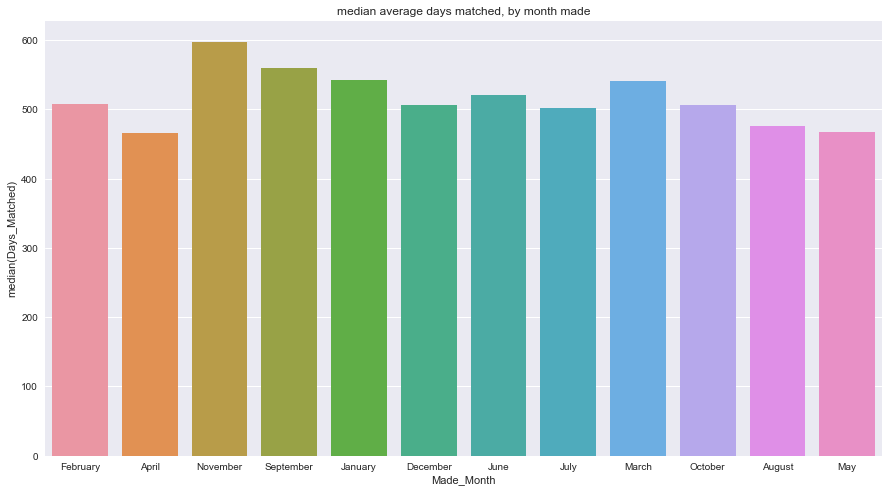

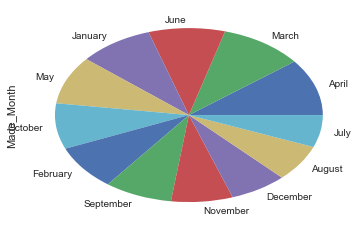

In [49]:
sns.barplot(x='Made_Month', y='Days_Matched', data=match, estimator=np.median, ci=None)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.title("median average days matched, by month made")
plt.show()

match['Made_Month'].value_counts().plot.pie()


In [50]:
match1 = match.copy()
match1['Made_Month']= match1['Made_Month'].replace({'December': 'Winter', 'January': 'Winter', 'February': 'Winter', \
                                                  'March': 'Spring', 'April': 'Spring', 'May': 'Spring', \
                                                  'June': 'Summer', 'July': 'Summer', 'August': 'Summer', \
                                                  'September': 'Fall', 'October': 'Fall', 'November': 'Fall'})

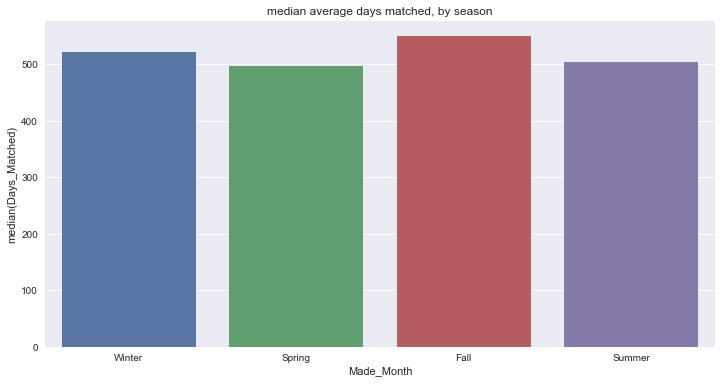

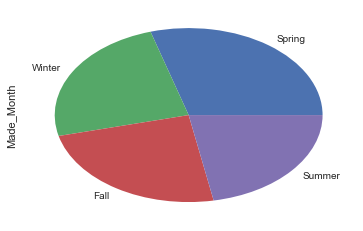

In [51]:
sns.barplot(x='Made_Month', y='Days_Matched', data=match1, estimator=np.median, ci=None)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.title("median average days matched, by season")
plt.show()

match1['Made_Month'].value_counts().plot.pie()

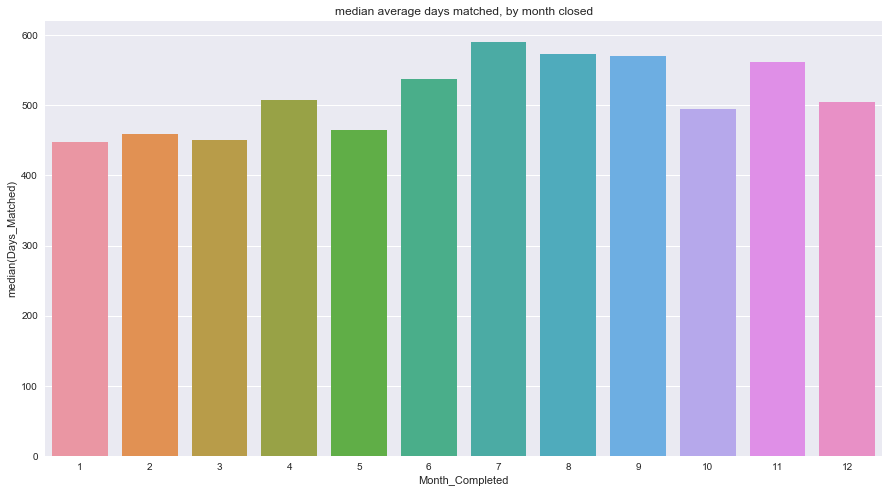

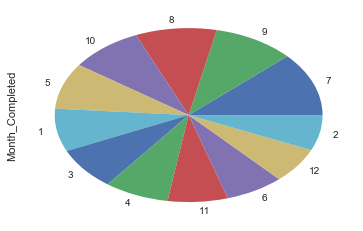

In [52]:
match2 = match.copy()
match2['Match_Completed_Date'] = pd.to_datetime(match2['Match_Completed_Date'])
match2['Month_Completed'] = match2['Match_Completed_Date'].dt.month

sns.barplot(x='Month_Completed', y='Days_Matched', data=match2, estimator=np.median, ci=None)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.title("median average days matched, by month closed")
plt.show()
match2['Month_Completed'].value_counts().plot.pie()

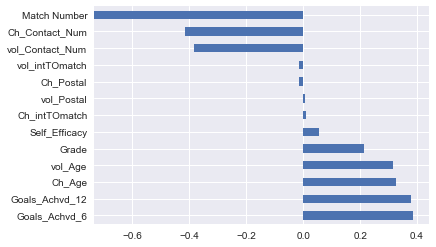

In [53]:
match3 = match.corr()
(match3
     .Days_Matched
     .drop(['Days_Matched']) # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())
plt.show()

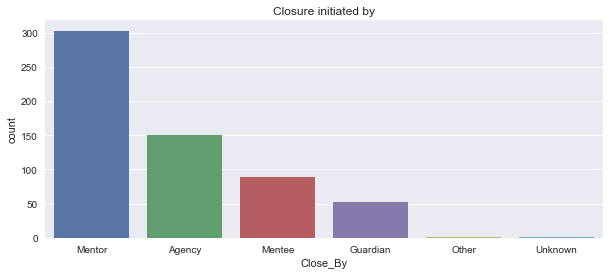

In [54]:
sns.countplot(x='Close_By', data=match)
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.title("Closure initiated by")
plt.show()

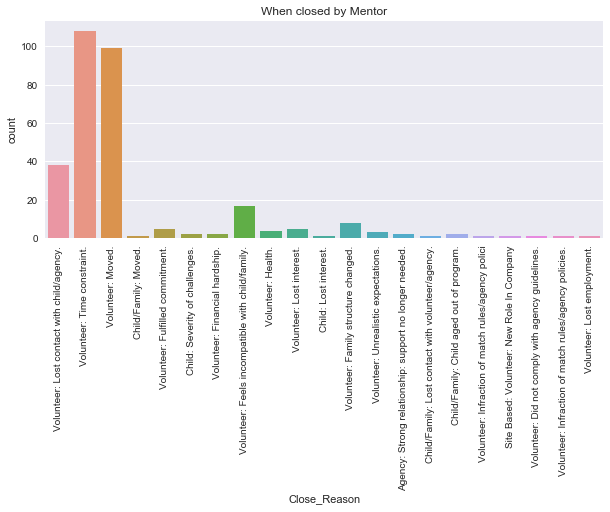

In [55]:
match4 = match.copy()
mentor_closed = match4[match4['Close_By']=='Mentor']
sns.countplot(x='Close_Reason', data=mentor_closed)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.title("When closed by Mentor")

plt.show()

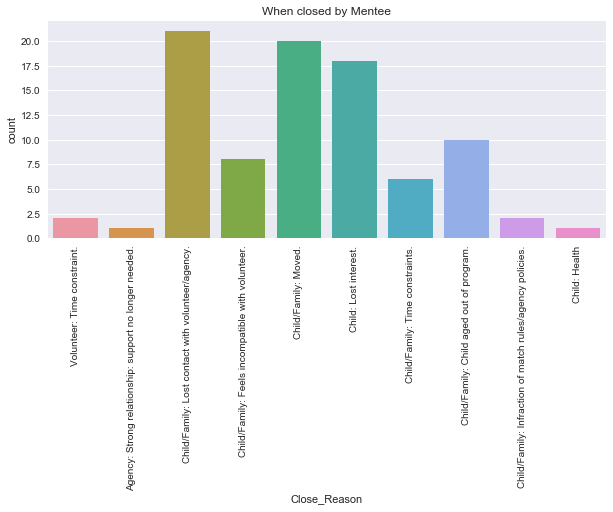

In [56]:
child_closed = match4[match4['Close_By']=='Mentee']
sns.countplot(x='Close_Reason', data=child_closed)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.title("When closed by Mentee")
plt.show()

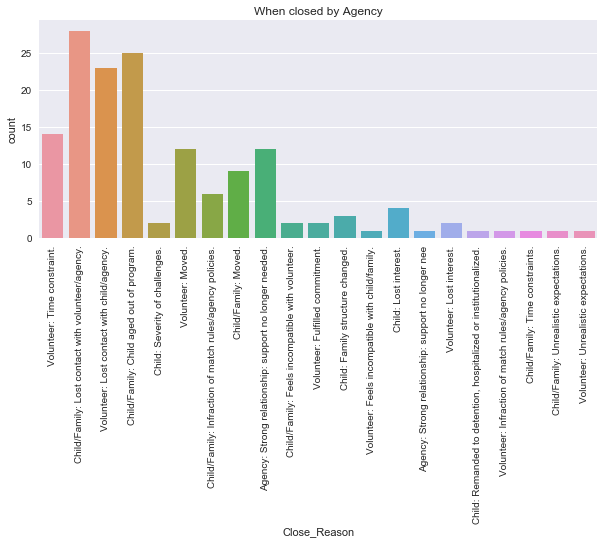

In [57]:
agency_closed = match4[match4['Close_By']=='Agency']
sns.countplot(x='Close_Reason', data=agency_closed)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.title("When closed by Agency")
plt.show()

In [58]:
w_o_sitebase['close_string'].value_counts()

Volunteer:       1073
Child/Family:     865
Agency:           172
Name: close_string, dtype: int64

In [95]:
closedBY = w_o_sitebase.copy()

closedBY['Match_Completed_Date'] = pd.to_datetime(closedBY['Match_Completed_Date'])
closedBY = closedBY.set_index(closedBY['Match_Completed_Date'])
closedBY = pd.get_dummies(data=closedBY, columns=['close_string'])

closedBY = closedBY.loc['2011-12':'2017-12'].resample('3M').sum()

# convert sum to percentages
closedBY['total_closed'] = closedBY['close_string_Agency:'] + closedBY['close_string_Child/Family:'] + \
closedBY['close_string_Volunteer:']
closedBY['Close_%_Agency'] = closedBY['close_string_Agency:'] / closedBY['total_closed']
closedBY['Close_%_Child'] = closedBY['close_string_Child/Family:'] / closedBY['total_closed']
closedBY['Close_%_Mentor'] = closedBY['close_string_Volunteer:'] / closedBY['total_closed']

# labels for xticks
dates = closedBY.index[::1] #jump one month only. however, it will jump 2 because we already resampled with '2M'
labels = dates.strftime('%b %y') #b=month, y=year



Oddly, starting from FY15, Mentors became the ones largely responsible for closures.



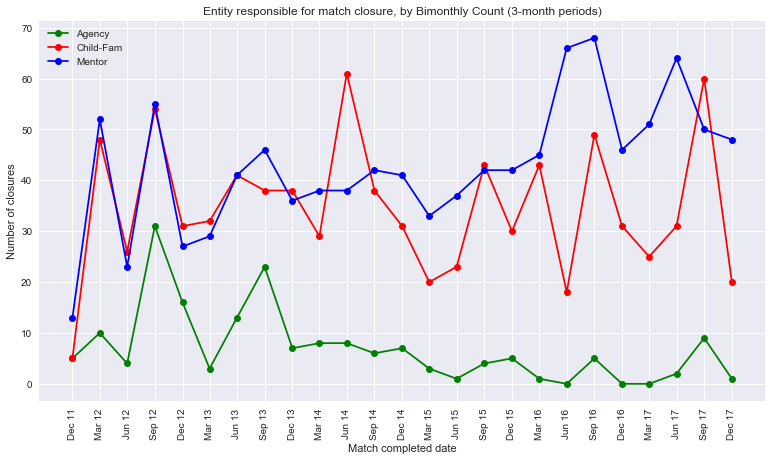

In [96]:
print("\nOddly, starting from FY15, Mentors became the ones largely responsible for closures.\n")
# Count of closures
plt.figure(figsize=(13,7))
plt.plot(closedBY['close_string_Agency:'], color='green', label='Agency', marker='o')
plt.plot(closedBY['close_string_Child/Family:'], color='red', label='Child-Fam', marker='o')
plt.plot(closedBY['close_string_Volunteer:'], color='blue', label='Mentor', marker='o')
plt.legend(loc='top left')
plt.xticks(dates, labels, rotation=90)
plt.title("Entity responsible for match closure, by Bimonthly Count (3-month periods)")
plt.ylabel("Number of closures")
plt.xlabel("Match completed date")
plt.show()

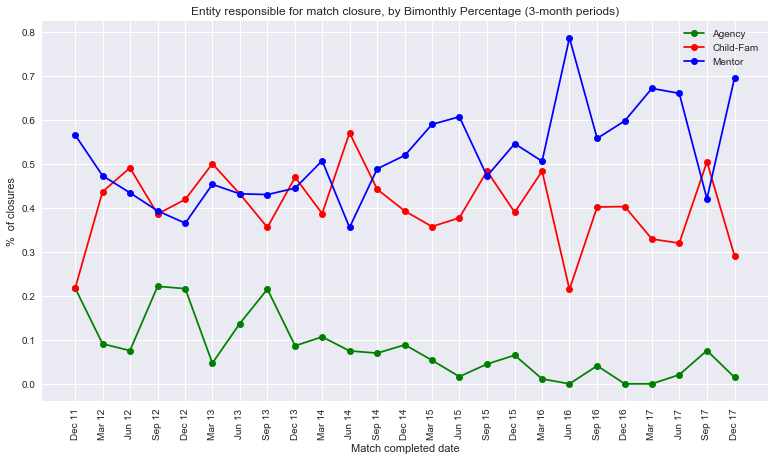

In [98]:
# Percentage of closures
plt.figure(figsize=(13,7))
plt.plot(closedBY['Close_%_Agency'], color='green', label='Agency', marker='o')
plt.plot(closedBY['Close_%_Child'], color='red', label='Child-Fam', marker='o')
plt.plot(closedBY['Close_%_Mentor'], color='blue', label='Mentor', marker='o')
plt.legend(loc='top left')
plt.xticks(dates, labels, rotation=90)
plt.title("Entity responsible for match closure, by Bimonthly Percentage (3-month periods)")
plt.ylabel("%  of closures")
plt.xlabel("Match completed date")
plt.show()


**Why so many Agency closures on July 2012?**

In [62]:
closedBY = w_o_sitebase.copy()

closedBY['Match_Completed_Date'] = pd.to_datetime(closedBY['Match_Completed_Date'])
closedBY = closedBY.set_index(closedBY['Match_Completed_Date'])
closedBY = pd.get_dummies(data=closedBY, columns=['close_string'])

closedBY['2012-07']['Close_Reason'].value_counts()

Agency: Strong relationship: support no longer needed.    24
Child/Family: Child aged out of program.                   9
Child/Family: Lost contact with volunteer/agency.          8
Volunteer: Moved.                                          6
Volunteer: Fulfilled commitment.                           6
Volunteer: Lost contact with child/agency.                 5
Volunteer: Time constraint.                                4
Child: Lost interest.                                      4
Child/Family: Moved.                                       3
Volunteer: Lost interest.                                  1
Child: Hospitalized and/or mental health instability.      1
Agency: Concern with Volunteer re: child safety.           1
Child/Family: Unrealistic expectations.                    1
Child/Family: Feels incompatible with volunteer.           1
Child: Severity of challenges.                             1
Name: Close_Reason, dtype: int64

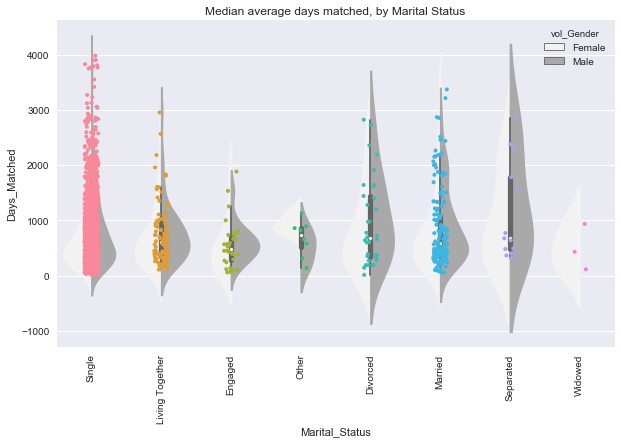

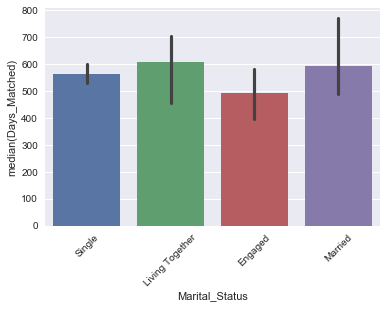

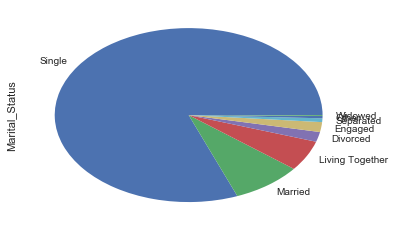

In [63]:
sns.violinplot(x='Marital_Status', y='Days_Matched', data=match, color='darkgray', inner='box', hue='vol_Gender', split=True)
sns.stripplot(x='Marital_Status', y='Days_Matched', data=match, jitter=True, size=4)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.title("Median average days matched, by Marital Status")
plt.show()


married_liv_together = match[(match['Marital_Status']=='Married') | (match['Marital_Status']=='Living Together') | \
                            (match['Marital_Status']=='Single') | (match['Marital_Status']=='Engaged')]
sns.barplot(x='Marital_Status', y='Days_Matched', data=married_liv_together, estimator=np.median)
plt.xticks(rotation=45)
plt.show()
match['Marital_Status'].value_counts().plot.pie()

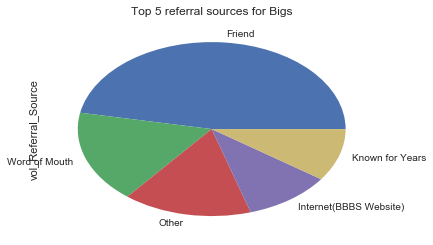

In [64]:
match['vol_Referral_Source'].value_counts()[:5].plot.pie()
plt.title("Top 5 referral sources for Bigs")
plt.show()

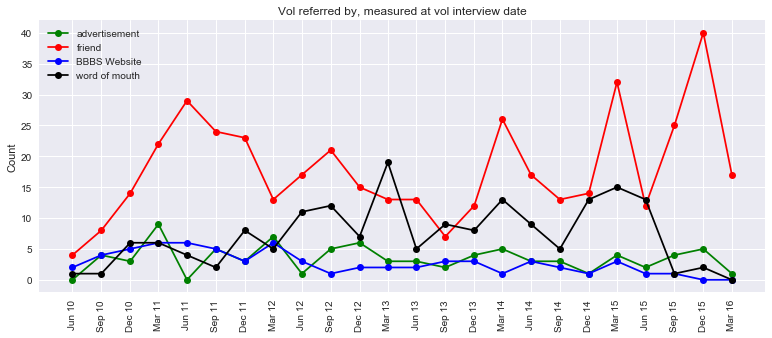

In [65]:
int_date_indxed = match.copy()
int_date_indxed = int_date_indxed[(int_date_indxed['vol_Referral_Source']=='Friend') | \
                                  (int_date_indxed['vol_Referral_Source']=='Other') | \
                                  (int_date_indxed['vol_Referral_Source']=='Word of Mouth') | \
                                  (int_date_indxed['vol_Referral_Source']=='Advertisement') | \
                                  (int_date_indxed['vol_Referral_Source']=='Internet(BBBS Website)')]
int_date_indxed.dropna(subset=['Volunteer_Interview_Date'], inplace=True)
int_date_indxed = int_date_indxed.set_index(int_date_indxed['Volunteer_Interview_Date'])
int_date_indxed = pd.get_dummies(data=int_date_indxed, columns=['vol_Referral_Source'])

int_date_indxed.head()
int_date_indxed = int_date_indxed.loc['2010-06':'2016-02'].resample('3M').sum()

# labels for xticks
dates = int_date_indxed.index[::1] #jump one month only. however, it will jump 2 because we already resampled with '2M'
labels = dates.strftime('%b %y') #b=month, y=year


plt.figure(figsize=(13,5))
plt.plot(int_date_indxed['vol_Referral_Source_Advertisement'], color='green', label='advertisement', marker='o')
plt.plot(int_date_indxed['vol_Referral_Source_Friend'], color='red', label='friend', marker='o')
plt.plot(int_date_indxed['vol_Referral_Source_Internet(BBBS Website)'], color='blue', label='BBBS Website', marker='o')
plt.plot(int_date_indxed['vol_Referral_Source_Word of Mouth'], color='black', label='word of mouth', marker='o')
plt.legend(loc='top left')
plt.xticks(dates, labels, rotation=90)
plt.title('Vol referred by, measured at vol interview date')
plt.ylabel("Count")
plt.show()

In [66]:
match['Volunteer_Interview_Date'].dt.year.value_counts()

2011.0    363
2015.0    313
2014.0    284
2012.0    279
2013.0    250
2010.0    185
2016.0    141
2009.0     87
2008.0     70
2007.0     46
2006.0     31
2005.0     13
2017.0     13
2004.0      7
2002.0      3
2003.0      2
2001.0      2
1999.0      1
Name: Volunteer_Interview_Date, dtype: int64

# Error bars in barplots

The error bars give a general idea of how precise a measurement is, or conversely, how far from the reported value the true (error free) value might be. Larger SD bars (error bars) = larger spread, data are more variable from the mean.

For example, for an average value, a LONG ERROR BAR means that the concentration of the values the average was calculated on is low, and thus that **the average value is uncertain.** Conversely, a short error bar means
that the concentration of values is high, and thus, that the average value is more certain.

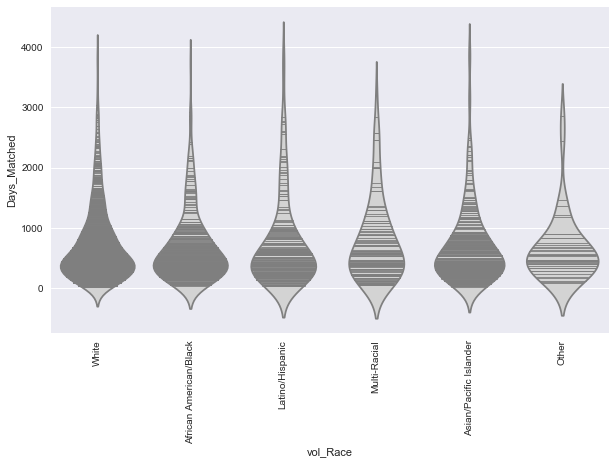

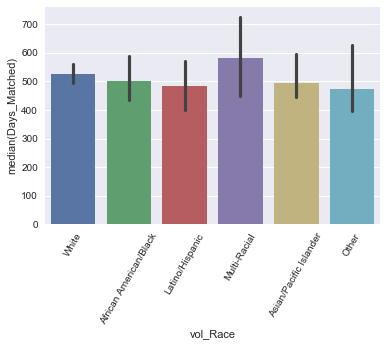

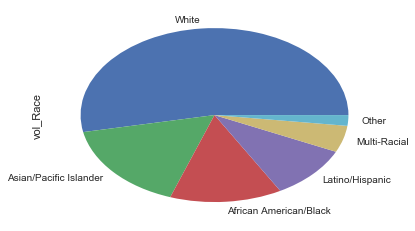

In [67]:
sns.violinplot(x='vol_Race', y='Days_Matched', data=match, color='lightgray', inner='stick')
#sns.stripplot(x='vol_Race', y='Days_Matched', data=match, jitter=True, size=3)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

sns.barplot(x='vol_Race', y='Days_Matched', data=match, estimator=np.median)
plt.xticks(rotation=60)
plt.show()
mentor_closed['vol_Race'].value_counts().plot.pie()

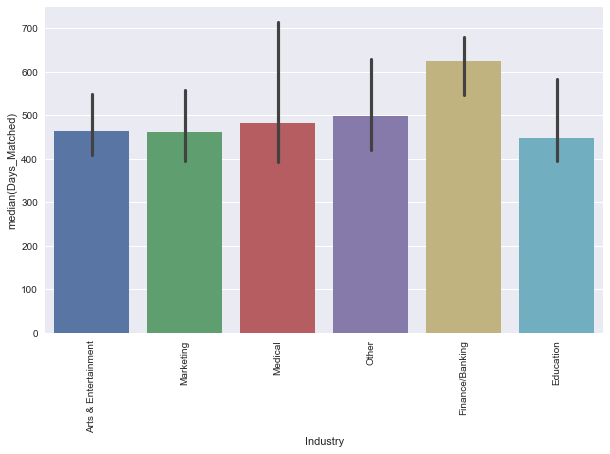

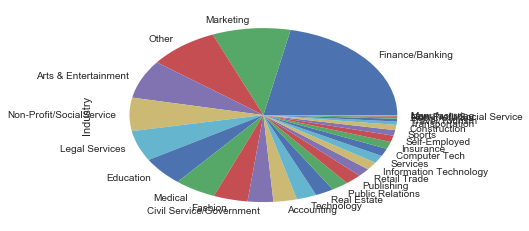

In [68]:
used_industries = match[(match['Industry']=='Finance/Banking') | (match['Industry']=='Marketing') | \
                        (match['Industry']=='Medical') | (match['Industry']=='Education') | \
                        (match['Industry']=='Arts & Entertainment') | (match['Industry']=='Other')]
sns.barplot(x='Industry', y='Days_Matched', data=used_industries, estimator=np.median)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()
match['Industry'].value_counts().plot.pie()

In [69]:
match['Industry'].value_counts()[:7]

Finance/Banking             422
Marketing                   183
Other                       164
Arts & Entertainment        139
Non-Profit/SocialService    120
Legal Services              110
Education                   103
Name: Industry, dtype: int64

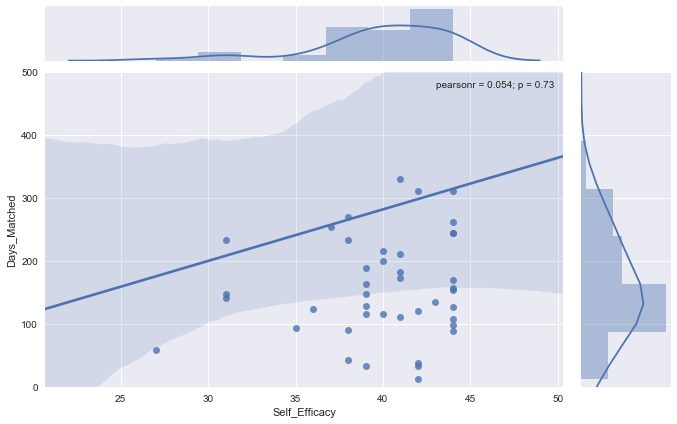

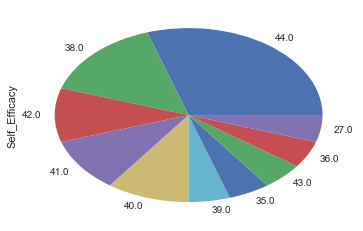

In [70]:
sns.jointplot(x='Self_Efficacy', y='Days_Matched', data=match, kind='reg')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.ylim(0,500)
plt.show()
mentor_closed['Self_Efficacy'].value_counts().plot.pie()


Religious volunteers seem to maintain longer matches


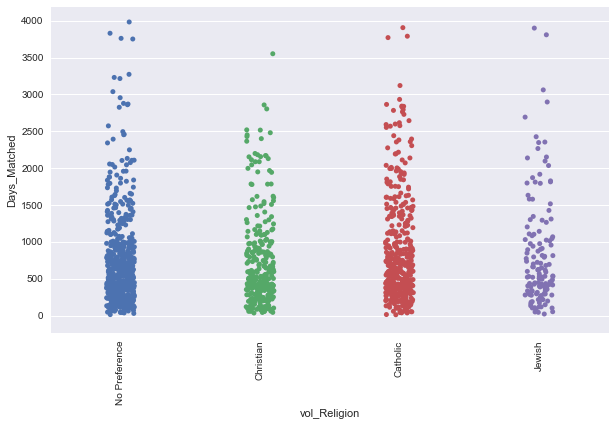

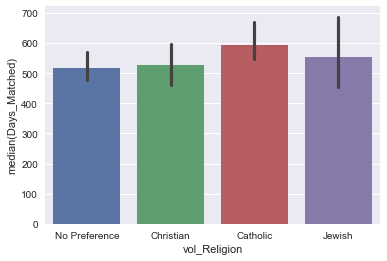

No Preference    581
Catholic         436
Christian        306
Jewish           142
Hindu             46
Name: vol_Religion, dtype: int64

In [71]:
print ("\nReligious volunteers seem to maintain longer matches")
used_religions = match[(match['vol_Religion']=='No Preference') | (match['vol_Religion']=='Catholic') | \
                      (match['vol_Religion']=='Christian') | (match['vol_Religion']=='Jewish')]
sns.stripplot(x='vol_Religion', y='Days_Matched', data=used_religions, jitter=True)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()
sns.barplot(x='vol_Religion', y='Days_Matched', data=used_religions, estimator=np.median)
plt.show()
match['vol_Religion'].value_counts()[:5]

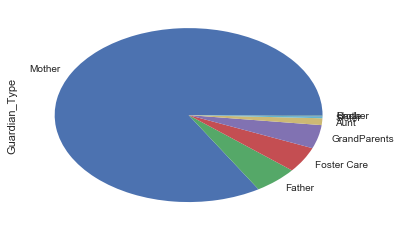

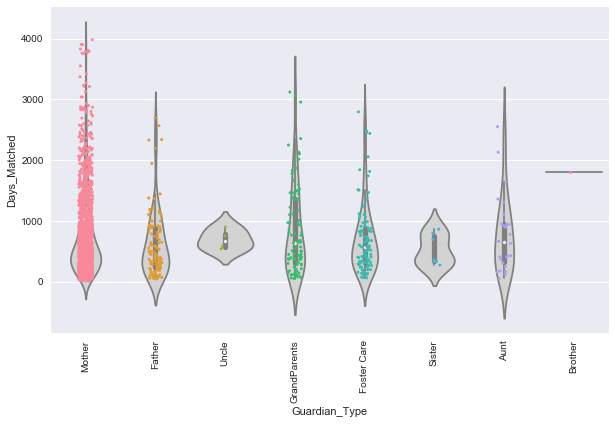

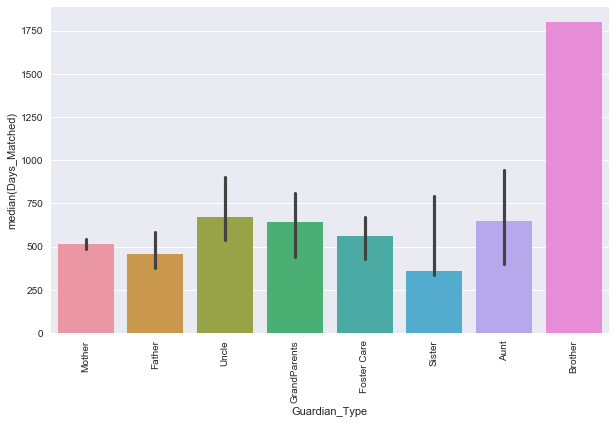

In [72]:
match['Guardian_Type'].value_counts().plot.pie()
plt.show()

sns.violinplot(x='Guardian_Type', y='Days_Matched', data=match, color='lightgray', inner='box')
sns.stripplot(x='Guardian_Type', y='Days_Matched', data=match, jitter=True, size=3)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

sns.barplot(x='Guardian_Type', y='Days_Matched', data=match, estimator=np.median)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

5 most common ethnicities of our children


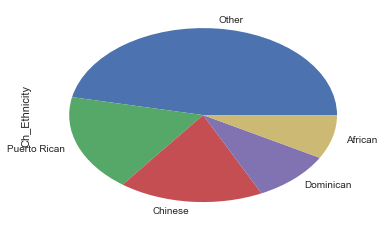

In [73]:
print("5 most common ethnicities of our children")
match['Ch_Ethnicity'].value_counts()[:5].plot.pie()
plt.show()

In [74]:
match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122 entries, 0 to 2121
Data columns (total 48 columns):
Match Number                2122 non-null int64
Ch_Contact_Num              2122 non-null int64
Ch_First                    2122 non-null object
Ch_Last                     2122 non-null object
vol_Contact_Num             2122 non-null int64
vol_First                   2122 non-null object
vol_Last                    2122 non-null object
Days_Matched                2122 non-null int64
Made_Month                  2122 non-null object
Close_By                    597 non-null object
Close_Reason                2122 non-null object
vol_Waiting_Date            2120 non-null object
Matched_Date                2122 non-null datetime64[ns]
Match_Completed_Date        2122 non-null object
Volunteer_Interview_Date    2090 non-null datetime64[ns]
vol_State                   2122 non-null object
vol_Postal                  2117 non-null float64
vol_Referral_Source         1634 non-null object

# Linear regression plots and Residuals

Doesn't appear to have a strong linear relationship


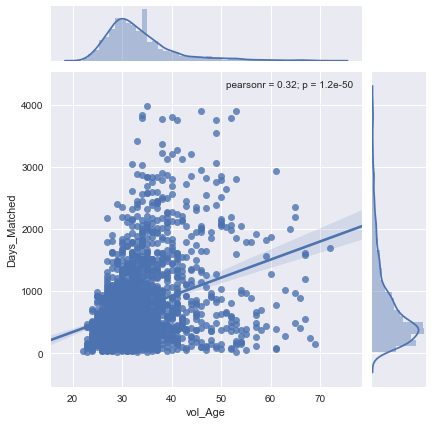

In [75]:
print("Doesn't appear to have a strong linear relationship")
sns.jointplot(x='vol_Age', y='Days_Matched', data=match, kind="reg") #pearson == correlation

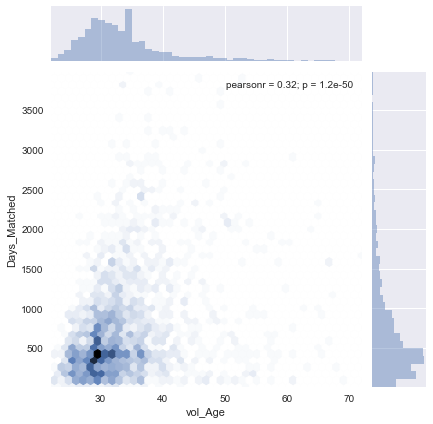

In [76]:
sns.jointplot(x='vol_Age', y='Days_Matched', data=match, kind="hex")

In [77]:
import scipy 
print("Pearson coefficient is: \n{}".format(np.corrcoef(match['vol_Age'], match['Days_Matched'])))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(match['vol_Age'], match['Days_Matched'])

print("\nR Square is: {}".format(r_value**2))

Pearson coefficient is: 
[[ 1.          0.31675268]
 [ 0.31675268  1.        ]]

R Square is: 0.10033226172459492


# Creating a more linear relationship

**Let's transform (non-linear transformation) x or y variables or both, to see whether we can get a stronger linear relationship**
- we use np.log(x or y) or 1/x or x**4, etc., to create a more linear relationship, which can be confirmed by a higher r square and better residual

R Square is higher but still doesn't seem to have a strong linear relationship


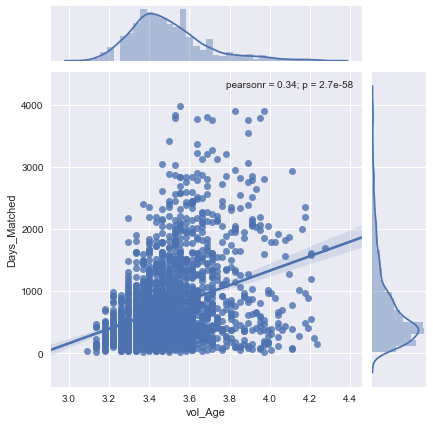

Pearson coefficient is: 
[[ 1.          0.33921379]
 [ 0.33921379  1.        ]]

R Square is: 0.11506599709687486


In [78]:
print ("R Square is higher but still doesn't seem to have a strong linear relationship")

# using log(x)
variable = match.copy()
variable['vol_Age'] = np.log(variable['vol_Age'])

sns.jointplot(x='vol_Age', y='Days_Matched', data=variable, kind="reg")
plt.show()

print("Pearson coefficient is: \n{}".format(np.corrcoef(variable['vol_Age'], variable['Days_Matched'])))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(variable['vol_Age'], variable['Days_Matched'])

print("\nR Square is: {}".format(r_value**2))

**Let's check the residual plot** (https://www.originlab.com/doc/Origin-Help/Residual-Plot-Analysis)

Residual plot is still not convincing, as it shows an increasing trend: we don't seem to have a strong linear fit.


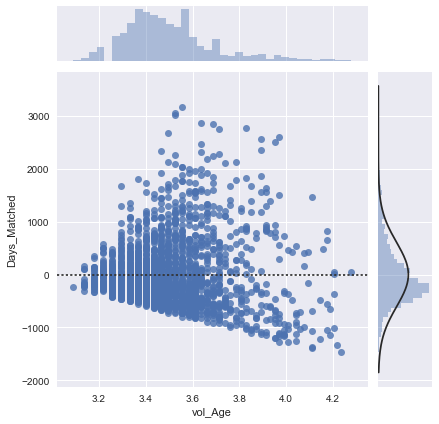

In [79]:
print("Residual plot is still not convincing, as it shows an increasing trend: we don't seem to have a strong linear fit.")
sns.jointplot(x='vol_Age', y='Days_Matched', data=variable, kind='resid')
plt.show()

**12 month goals**

In [80]:
match['Goals_Achvd_12'].value_counts()

0.0     444
11.0     45
12.0     44
14.0     43
15.0     40
13.0     38
16.0     36
8.0      29
10.0     26
9.0      24
7.0       9
4.0       7
6.0       3
26.0      1
25.0      1
18.0      1
27.0      1
23.0      1
20.0      1
19.0      1
3.0       1
22.0      1
5.0       1
Name: Goals_Achvd_12, dtype: int64

no linear realtionship between sum goal achievement and days matched


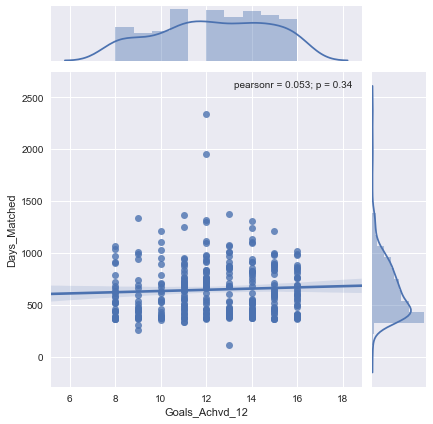

In [81]:
print("no linear realtionship between sum goal achievement and days matched")
goals8_16 = match.copy()
goals8_16 = goals8_16.loc[(goals8_16['Goals_Achvd_12'] > 7) & (goals8_16['Goals_Achvd_12'] < 17)]
sns.jointplot(x='Goals_Achvd_12', y='Days_Matched', data=goals8_16, kind='reg')
plt.show()

# Regression with orders 1,2,3

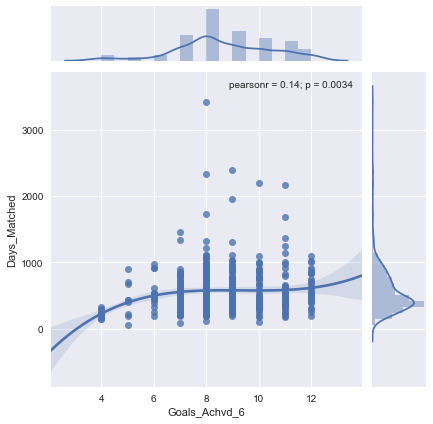

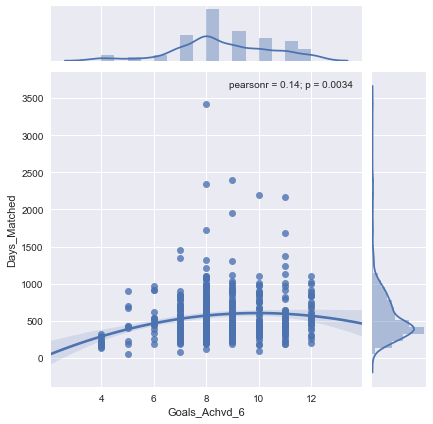

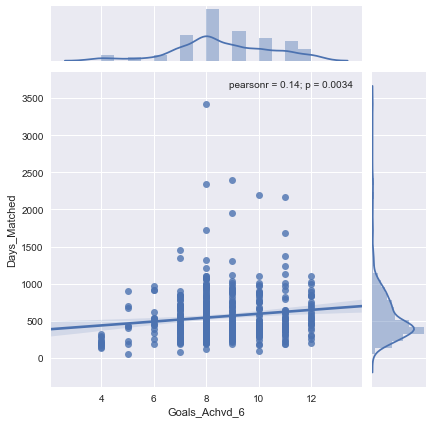

In [82]:
goals4_12 = match.copy()
goals4_12 = goals4_12.loc[(goals4_12['Goals_Achvd_6'] > 3) & (goals4_12['Goals_Achvd_6'] < 13)]

sns.jointplot(x='Goals_Achvd_6', y='Days_Matched', data=goals4_12, order=3, kind='reg')
sns.jointplot(x='Goals_Achvd_6', y='Days_Matched', data=goals4_12, order=2, kind='reg')
sns.jointplot(x='Goals_Achvd_6', y='Days_Matched', data=goals4_12, order=1, kind='reg')
plt.show()

# More Advanced Plots


The area under a PROBABILITY DENSITY function for a given range gives the probability of a random variable being in that range.


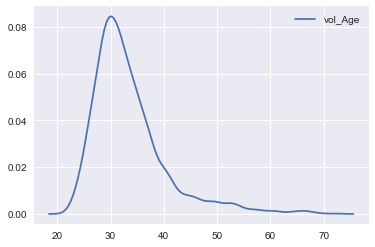

In [83]:
print("\nThe area under a PROBABILITY DENSITY function for a given range \
gives the probability of a random variable being in that range.")
sns.kdeplot(match['vol_Age'])


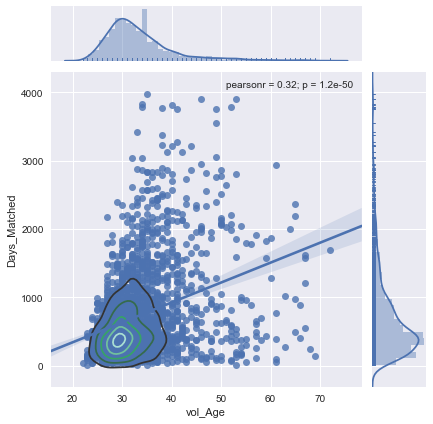

In [84]:
sns.jointplot(x='vol_Age', y='Days_Matched', data=match, kind='reg')\
.plot_joint(sns.kdeplot, n_levels=6)\
.plot_marginals(sns.rugplot)
plt.show()

**It appears that vols with Associate Degrees have the strongest linear relationsihp between their age and days matched**

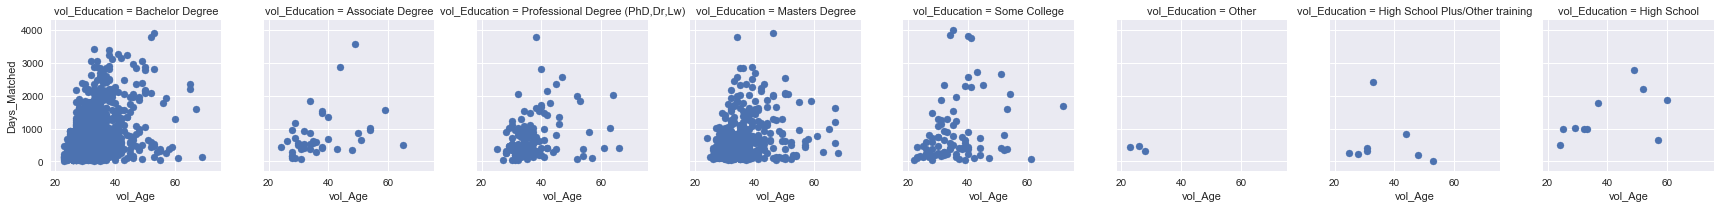

In [85]:
g = sns.FacetGrid(match, col="vol_Education") 
g.map(plt.scatter, "vol_Age", "Days_Matched")

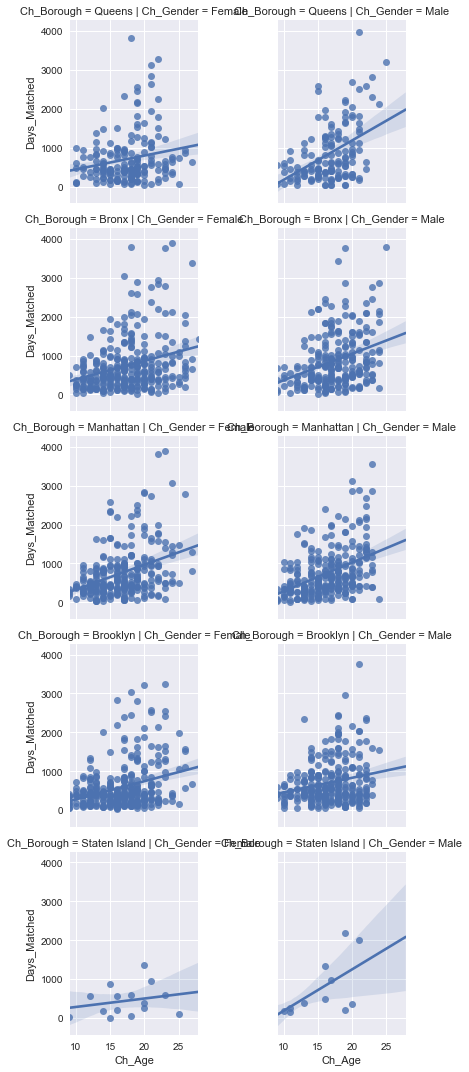

In [86]:
f = sns.FacetGrid(data=match, col='Ch_Gender', row='Ch_Borough')
f.map(sns.regplot, "Ch_Age", "Days_Matched")

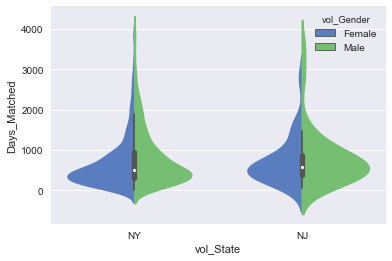

In [87]:
NY_NJ = match[(match['vol_State']=='NJ') | (match['vol_State']=='NY')]
sns.violinplot('vol_State', y='Days_Matched', data=NY_NJ, inner='box', scale='count', hue='vol_Gender', palette='muted', split=True)


It seems like male matches tend to stay together longer


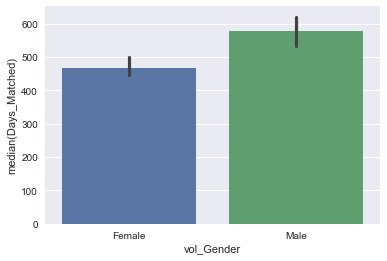

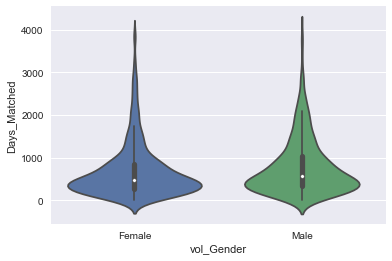

In [88]:
print("\nIt seems like male matches tend to stay together longer")
sns.barplot(x='vol_Gender', y='Days_Matched', data=match, estimator=np.median)
plt.show()
sns.violinplot(match['vol_Gender'], y=match['Days_Matched'], inner='box', scale='count') #combination of boxplot and KDE
plt.show()

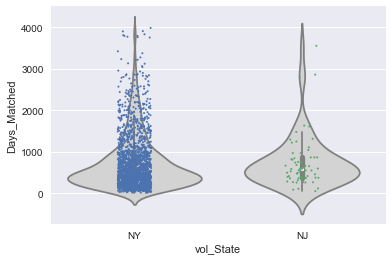

In [89]:
sns.violinplot('vol_State', y='Days_Matched', data=NY_NJ, inner='box', color='lightgray')
sns.stripplot('vol_State', y='Days_Matched', data=NY_NJ, jitter=True, size=2)

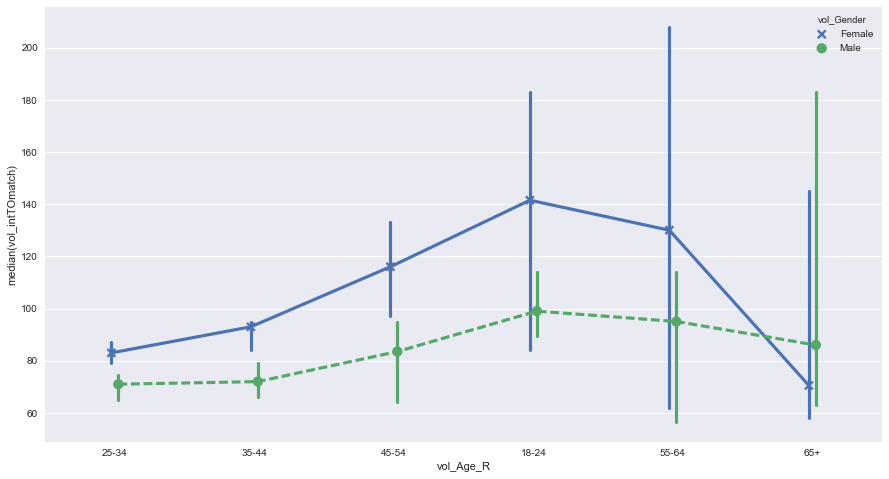

In [90]:
over_10_days = match.copy()
over_10_days = over_10_days[over_10_days['vol_intTOmatch']>10]
sns.pointplot('vol_Age_R', 'vol_intTOmatch', data=over_10_days, estimator=np.median, hue='vol_Gender', dodge=True,\
              linestyles=["-", "--"], markers=["x", "o"])
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

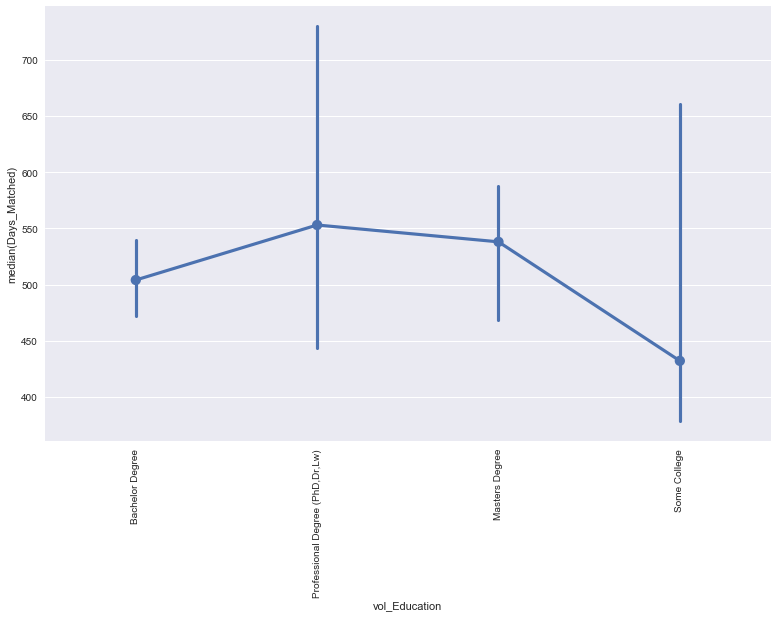

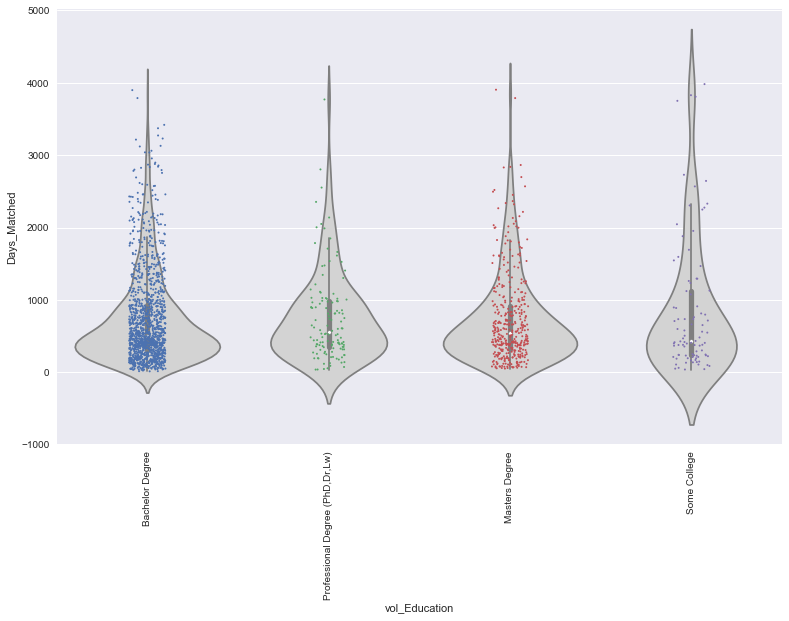

In [91]:
comon_degrees = match[(match['vol_Education'] != 'High School Plus/Other training') & \
      (match['vol_Education'] != 'Associate Degree') & (match['vol_Education'] != 'High School') &\
      (match['vol_Education'] != 'Other')]

sns.pointplot('vol_Education', 'Days_Matched',data=comon_degrees, estimator=np.median)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(13,8)
plt.show()


sns.violinplot('vol_Education', y='Days_Matched', data=comon_degrees, inner='box', color='lightgray')
sns.stripplot('vol_Education', y='Days_Matched', data=comon_degrees, jitter=True, size=2)
plt.xticks(rotation='vertical')
fig=plt.gcf()
fig.set_size_inches(13,8)
plt.show()

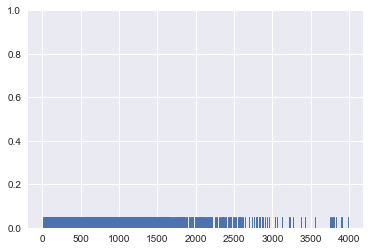

In [92]:
sns.rugplot(match['Days_Matched'])